In [1]:
import numpy as np

numbers = np.linspace(0, 3-1, 3)
numbers

array([0., 1., 2.])

In [2]:
import pandas as pd

df_hsp = pd.read_csv("HSP_song_collab_small.csv", sep=",")
df_sup = pd.read_csv("data_superstar_v1_0_small.csv", sep=",")

In [3]:
df_hsp['date'] = pd.to_datetime(df_hsp['release_date'])
df_hsp.sort_values(by="date", inplace=True)

split_day = df_hsp["date"].iloc[-1]  - pd.DateOffset(years=1)
hsp_train_df = df_hsp[(df_hsp["date"]  < split_day)].copy()
hsp_test_df = df_hsp[(df_hsp["date"]  >= split_day)].copy()

In [4]:
df_sup['date'] = pd.to_datetime(df_sup['release_date'])
df_sup.sort_values(by="date", inplace=True)

split_day = df_sup["date"].iloc[-1]  - pd.DateOffset(years=1)
sup_train_df = df_sup[(df_sup["date"]  < split_day)].copy()
sup_test_df = df_sup[(df_sup["date"]  >= split_day)].copy()

now check the intersections of ids

In [5]:
hsp_train_set = set(hsp_train_df["song_id"]) 
hsp_test_set = set(hsp_test_df["song_id"])
len(hsp_train_set), len(hsp_test_set)

(302916, 54250)

In [6]:
sup_train_set = set(sup_train_df["song_id"])
sup_test_set = set(sup_test_df["song_id"])
len(sup_train_set), len(sup_test_set)

(302916, 54250)

In [7]:
intersect_train = sup_train_set & hsp_train_set
intersect_test = sup_test_set & hsp_test_set
len(intersect_train), len(intersect_test)

(302916, 54250)

proved that only the order might vary

In [8]:
type(intersect_train)

set

feature selection


In [9]:
df_sup["hit"]

0         0.0
64        0.0
63        0.0
62        0.0
61        0.0
         ... 
357140    1.0
357139    1.0
357164    1.0
357151    1.0
357165    1.0
Name: hit, Length: 357166, dtype: float64

In [10]:
df_without_strings = df_sup.select_dtypes(exclude=['object']) #include onehot enc for some string values /different encod
df_without_strings.drop(columns="date", inplace=True)
df_without_strings

,song_popularity,explicit,track_number,num_artists,num_available_markets,duration_ms,key,mode,time_signature,acousticness,...,superstar_v4_x,superstar_v4_y,superstar_v5_x,superstar_v5_y,success_rate_x,success_rate_y,hits_in_past_x,hits_in_past_y,superstar_x,superstar_y
0,0.0,False,19.0,1.0,74.0,163255.0,2.0,1.0,4.0,0.584000,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
64,33.0,False,10.0,1.0,77.0,195707.0,9.0,0.0,4.0,0.231000,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
63,52.0,True,2.0,1.0,77.0,167253.0,11.0,0.0,4.0,0.014800,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
62,46.0,False,4.0,1.0,77.0,263120.0,4.0,0.0,4.0,0.099600,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
61,44.0,False,1.0,1.0,77.0,182280.0,7.0,1.0,4.0,0.054800,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357140,5.0,False,6.0,1.0,79.0,192401.0,2.0,1.0,4.0,0.000465,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
357139,1.0,False,25.0,1.0,76.0,194907.0,8.0,1.0,4.0,0.038800,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
357164,3.0,False,15.0,1.0,78.0,172147.0,1.0,1.0,4.0,0.727000,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
357151,26.0,False,5.0,1.0,79.0,205707.0,9.0,1.0,4.0,0.224000,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0


In [11]:
y = df_without_strings["hit"].copy()
df_without_strings.drop(columns="hit", inplace=True)
X = df_without_strings

In [12]:
from sklearn.preprocessing import MinMaxScaler

numerical_cols = X.select_dtypes(include=['number']).columns

scaler = MinMaxScaler()

# Apply the scaler to the numerical columns
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [13]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE

select_k_best = SelectKBest(score_func=f_classif, k=20)
X_new = select_k_best.fit_transform(X, y)
selected_features = X.columns[select_k_best.get_support()]
print("Selected features using SelectKBest:", selected_features.tolist())

Selected features using SelectKBest: ['song_popularity', 'explicit', 'energy', 'instrumentalness', 'loudness', 'betweenesscentrality_x', 'clustering_x', 'eccentricity_x', 'eigencentrality_x', 'weighted degree_x', 'Cluster_x', 'years_on_charts', 'superstar_v1_x', 'superstar_v2_x', 'superstar_v3_x', 'superstar_v4_x', 'superstar_v5_x', 'success_rate_x', 'hits_in_past_x', 'superstar_x']


In [14]:
feature_scores = select_k_best.scores_
print("Feature scores:", feature_scores)

# Using get_support method (without indices)
#selected_features = select_k_best.get_support(indices=False)
#print("Selected features based on scores:", selected_features)

Feature scores: [1.36109021e+04 5.83308023e+02 8.90885948e+01 7.83698101e+01
 1.51361621e+01 3.12946121e+01 6.43326012e-02 6.27264925e+00
 2.29823710e+01 9.12271948e+01 1.99829012e+01 2.67732488e+02
 1.62110254e+03 5.00730610e-01 6.54437286e+02 1.00658964e+01
 1.94922205e+02 2.80077663e+00 3.71206663e+02 1.21995492e+02
 4.27470476e+02 7.85316000e+00 5.64902406e+02 5.43775803e+02
 1.15498917e+03 6.12071111e+01 4.32387750e+02 8.83866296e+00
 1.35915542e+01 1.26953284e+01 1.70375090e+01 9.28400349e+01
 2.03115918e+00 1.02597862e+01 1.58434760e+01 3.07465271e+01
 7.95015739e+00 5.42436018e+01 4.87820264e+05 4.52149477e+03
 6.41238649e+00 3.61414465e+03 8.92958676e+00 4.97508753e+03
 4.85842337e+00 3.85051437e+03 7.62953224e+00 4.58787721e+03
 6.26675234e+00 7.54010926e+03 2.15301496e+00 5.65954999e+03
 2.28807536e+00 3.38433114e+03 7.21682842e+00]


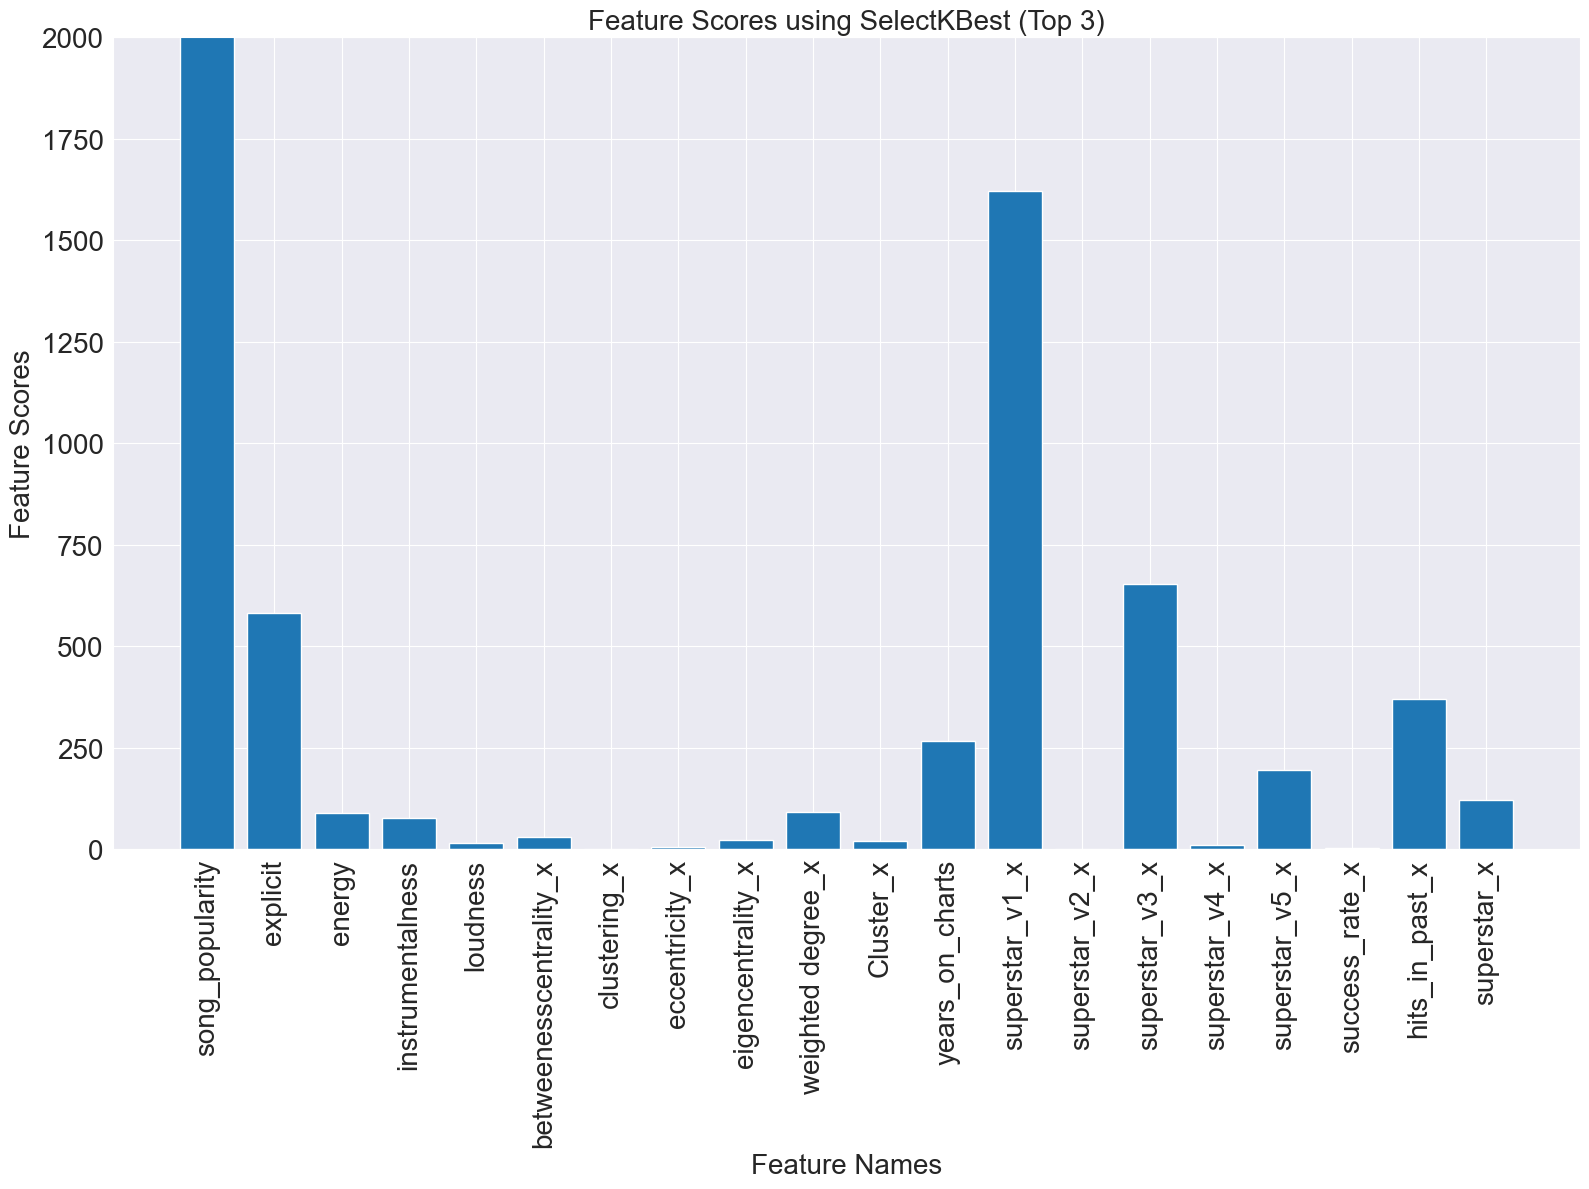

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
plt.bar(selected_features[:20], feature_scores[:20])
plt.xlabel("Feature Names", fontsize=20)
plt.ylabel("Feature Scores", fontsize=20)
plt.title("Feature Scores using SelectKBest (Top 3)", fontsize=20)
plt.xticks(rotation=90, fontsize=20)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=20)  # Rotate x-axis labels for better readability
plt.ylim(0, 2000)
plt.tight_layout()
plt.show()

In [16]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

select_k_best2 = SelectKBest(score_func=mutual_info_classif, k=20)
X_new = select_k_best2.fit_transform(X, y)
selected_features = X.columns[select_k_best2.get_support()]
print("Selected features using SelectKBest:", selected_features.tolist())

Selected features using SelectKBest: ['song_popularity', 'num_available_markets', 'mode', 'time_signature', 'closnesscentrality_x', 'eigencentrality_x', 'pagerank_x', 'Cluster_x', 'artist1_num', 'years_on_charts', 'superstar_v1_x', 'superstar_v1_y', 'superstar_v2_x', 'superstar_v2_y', 'superstar_v3_x', 'superstar_v3_y', 'superstar_v4_x', 'superstar_v4_y', 'superstar_v5_x', 'superstar_v5_y']


In [17]:
feature_scores = select_k_best2.scores_
print("Feature scores:", feature_scores)

Feature scores: [1.10519683e-02 1.56713405e-03 2.69890747e-03 2.41633785e-03
 7.95590960e-02 4.98027732e-04 6.77136900e-03 7.23654130e-02
 7.65136137e-02 1.14331016e-03 4.74147405e-04 9.33325251e-04
 3.35002037e-03 3.30291980e-04 1.52930782e-03 7.84284319e-05
 6.03191919e-04 7.10121280e-04 8.29324742e-03 1.40081804e-02
 2.92814338e-03 3.04377912e-03 7.61461041e-03 3.91959011e-02
 8.66561761e-03 9.70934779e-03 1.82779583e-02 6.29021294e-05
 4.98269414e-04 1.41992180e-04 7.87351181e-05 6.96428642e-04
 5.33324707e-04 2.18953168e-04 3.53671170e-04 7.66470528e-04
 1.28563535e-02 4.38893424e-04 4.26083604e-02 1.01679901e-01
 7.73432860e-02 8.25780515e-02 6.20820663e-02 9.46788115e-02
 7.33328146e-02 1.08793698e-01 8.40507252e-02 1.01976895e-01
 7.78150513e-02 6.02996590e-03 1.02994551e-04 4.18608253e-03
 0.00000000e+00 3.96449564e-03 0.00000000e+00]


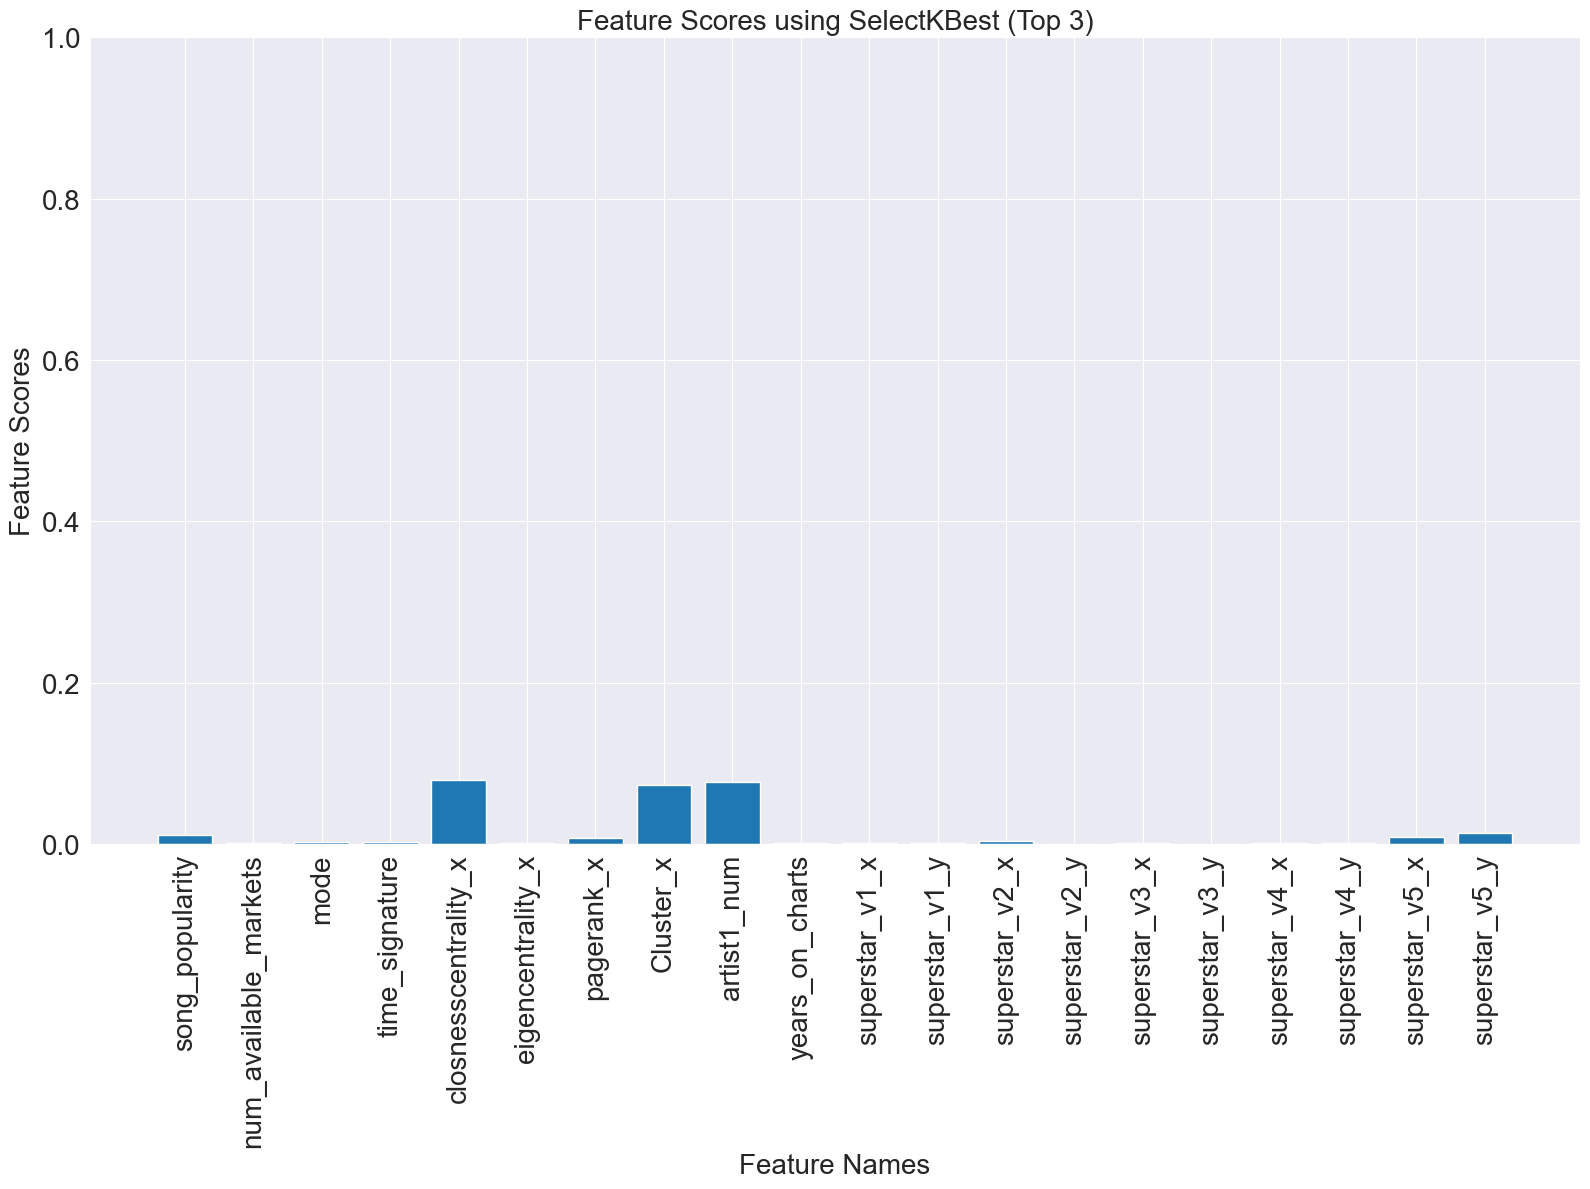

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
plt.bar(selected_features[:20], feature_scores[:20])
plt.xlabel("Feature Names", fontsize=20)
plt.ylabel("Feature Scores", fontsize=20)
plt.title("Feature Scores using SelectKBest (Top 3)", fontsize=20)
plt.xticks(rotation=90, fontsize=20)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=20)  # Rotate x-axis labels for better readability
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [19]:
df_one_hot = pd.get_dummies(X, columns=['Cluster_x', "Cluster_y"], drop_first=True)
df_one_hot

,song_popularity,explicit,track_number,num_artists,num_available_markets,duration_ms,key,mode,time_signature,acousticness,...,Cluster_x_0.4,Cluster_x_0.6000000000000001,Cluster_x_0.8,Cluster_x_1.0,Cluster_y_0.16666666666666666,Cluster_y_0.3333333333333333,Cluster_y_0.5,Cluster_y_0.6666666666666666,Cluster_y_0.8333333333333333,Cluster_y_0.9999999999999999
0,0.00,False,0.197802,0.0,0.936709,0.026784,0.181818,1.0,0.8,0.586345,...,False,False,False,False,False,False,False,False,False,False
64,0.33,False,0.098901,0.0,0.974684,0.032166,0.818182,0.0,0.8,0.231928,...,False,False,False,False,False,False,False,False,False,False
63,0.52,True,0.010989,0.0,0.974684,0.027447,1.000000,0.0,0.8,0.014859,...,False,False,False,False,False,False,False,False,False,False
62,0.46,False,0.032967,0.0,0.974684,0.043344,0.363636,0.0,0.8,0.100000,...,False,False,False,False,False,False,False,False,False,False
61,0.44,False,0.000000,0.0,0.974684,0.029939,0.636364,1.0,0.8,0.055020,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357140,0.05,False,0.054945,0.0,1.000000,0.031617,0.181818,1.0,0.8,0.000467,...,True,False,False,False,False,False,False,False,False,False
357139,0.01,False,0.263736,0.0,0.962025,0.032033,0.727273,1.0,0.8,0.038956,...,True,False,False,False,False,False,False,False,False,False
357164,0.03,False,0.153846,0.0,0.987342,0.028259,0.090909,1.0,0.8,0.729920,...,False,False,True,False,False,False,False,False,False,False
357151,0.26,False,0.043956,0.0,1.000000,0.033824,0.818182,1.0,0.8,0.224900,...,True,False,False,False,False,False,False,False,False,False


In [20]:
from sklearn.feature_selection import SelectKBest, chi2

select_k_best3 = SelectKBest(score_func=chi2, k=20)
X_new = select_k_best3.fit_transform(df_one_hot, y)
selected_features = df_one_hot.columns[select_k_best3.get_support()]
print("Selected features using SelectKBest:", selected_features.tolist())

Selected features using SelectKBest: ['song_popularity', 'explicit', 'num_artists', 'instrumentalness', 'betweenesscentrality_x', 'clustering_x', 'eccentricity_x', 'eigencentrality_x', 'weighted degree_x', 'years_on_charts', 'superstar_v1_x', 'superstar_v2_x', 'superstar_v3_x', 'superstar_v4_x', 'superstar_v5_x', 'success_rate_x', 'hits_in_past_x', 'superstar_x', 'Cluster_x_0.8', 'Cluster_y_0.16666666666666666']


In [21]:
feature_scores = select_k_best3.scores_
print("Feature scores:", feature_scores)

Feature scores: [3.37167105e+03 5.41460664e+02 7.24167197e+00 7.06742964e+01
 7.89026493e-01 1.86782978e-01 1.40986453e-02 1.98261508e+00
 1.88516732e-01 3.12971850e+01 8.92305367e-01 2.82180550e+01
 7.63003753e+02 8.31449511e-02 5.17978624e+00 1.45369450e+00
 2.72322411e+01 7.84479008e-02 2.91379662e+02 6.25369171e+01
 1.04273675e+02 1.26707506e+00 2.08788555e+02 1.53000150e+02
 4.45197495e+02 1.08763525e+01 7.70997047e+00 7.54442585e+00
 6.25869674e+00 3.85727226e+00 5.14093595e+01 1.27074041e+00
 3.84658190e+00 3.63023850e+00 1.13085259e+00 3.38063785e+01
 4.93369675e+04 2.46315010e+02 4.56060338e-02 1.27962651e+02
 4.08203372e-02 2.41406629e+02 3.07430485e-02 2.48949735e+02
 6.29756031e-02 2.52873196e+02 4.50783039e-02 1.16328087e+03
 3.82280148e-01 8.97325459e+02 4.57078702e-01 3.05594643e+03
 7.14165952e+00 3.68035944e+01 2.86918563e-04 6.55149419e-02
 2.24587619e+02 2.82772532e+00 7.35166112e+01 6.92283276e+00
 4.43353046e+00 8.63752230e+00 3.55214120e-01 4.06032354e+00]


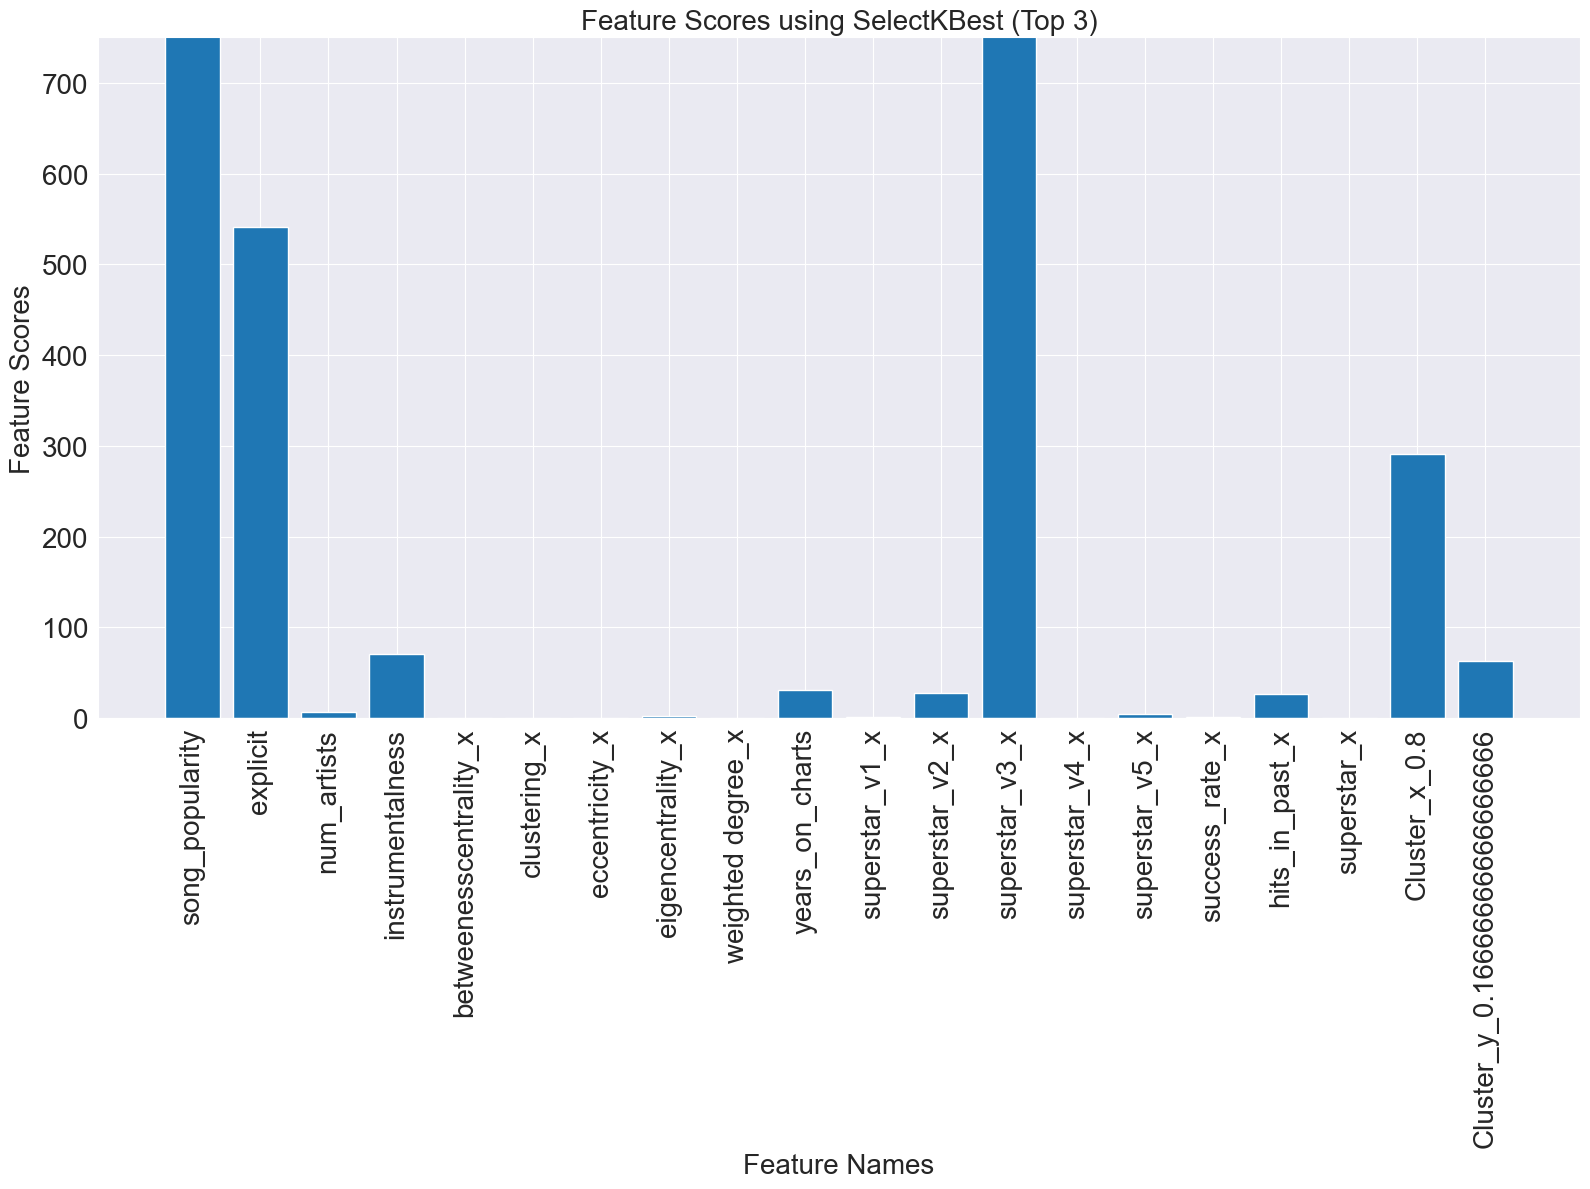

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
plt.bar(selected_features[:20], feature_scores[:20])
plt.xlabel("Feature Names", fontsize=20)
plt.ylabel("Feature Scores", fontsize=20)
plt.title("Feature Scores using SelectKBest (Top 3)", fontsize=20)
plt.xticks(rotation=90, fontsize=20)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=20)  # Rotate x-axis labels for better readability
plt.ylim(0, 750)
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

data = pd.read_csv("data_superstar_v1_0_small.csv", delimiter=",")
data['date'] = pd.to_datetime(data['release_date'])
data.sort_values(by="date", inplace=True)


# Drop columns not in the list
data["explicit"] = data["explicit"].astype(int)


def find_min_max(df):
    # Select only numeric columns
    numeric_cols = df.select_dtypes(include=['number'])

    # Find max and min values for each numeric column
    min_max_values = {}
    for col in numeric_cols.columns:
        min_value = df[col].min()
        max_value = df[col].max()
        min_max_values[col] = {'min': min_value, 'max': max_value}

    return min_max_values


min_max_val = find_min_max(data)

y = data["hit"]
X = data.drop(columns=["hit"])


def preprocess(df, min_max_values, exclude_cols=None):
    missing_numerical = df.select_dtypes(include=['number']).isnull().sum()
    # Fill missing values with mean for each numeric attribute
    imputer = SimpleImputer(strategy='mean')
    df_filled = df.copy()
    for col in missing_numerical.index:
        if missing_numerical[col] > 0:
            df_filled[col] = imputer.fit_transform(df[[col]])

    # Normalize numerical features into [0, 1] range with MinMaxScaler
    if exclude_cols:
        numerical_cols = df_filled.select_dtypes(include=['number']).columns.difference(exclude_cols)
    else:
        numerical_cols = df_filled.select_dtypes(include=['number']).columns

    # print("numerical columns:", numerical_cols)

    for column_name in numerical_cols:
        df_filled[column_name] = (df_filled[column_name] - min_max_values[column_name]["min"]) / (
                min_max_values[column_name]["max"] - min_max_values[column_name]["min"])

    df_normalized = pd.DataFrame(df_filled, columns=numerical_cols)

    # One-hot encode categorical features
    encoder = OneHotEncoder(handle_unknown='ignore')
    if exclude_cols:
        categorical_cols = df.select_dtypes(include=['object']).columns.difference(exclude_cols)
    else:
        categorical_cols = df.select_dtypes(include=['object']).columns
    df_encoded = encoder.fit_transform(df[categorical_cols])

    # print(categorical_cols)

    # Convert the sparse matrix to dense array
    df_encoded_dense = df_encoded.toarray()

    # Concatenate numerical and encoded categorical features
    df_processed = np.hstack([df_normalized.values, df_encoded_dense])

    return df_processed

split_day = X["date"].iloc[-1] - pd.DateOffset(years=1)
X_train = X[(X["date"] < split_day)].copy()
X_test = X[(X["date"] >= split_day)].copy()

sep_index = X_train.shape[0]
y_train = y.iloc[:sep_index].copy()
y_test = y.iloc[sep_index:].copy()

In [4]:
X_train = X_train.select_dtypes(exclude=['object']) #include onehot enc for some string values /different encod
X_train.drop(columns="date", inplace=True)
X_train.drop(columns="song_popularity", inplace=True)
X_test = X_test.select_dtypes(exclude=['object']) #include onehot enc for some string values /different encod
X_test.drop(columns="date", inplace=True)
X_test.drop(columns="song_popularity", inplace=True)

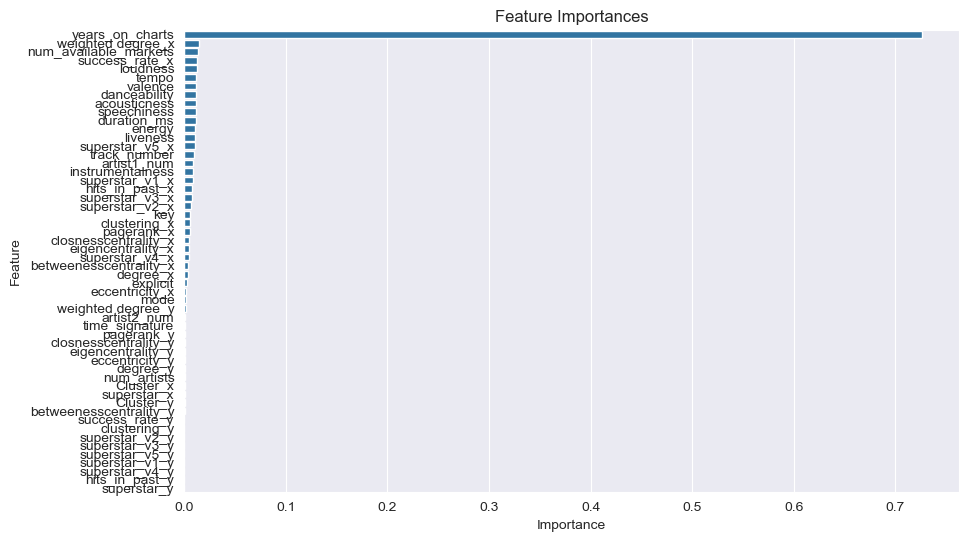

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get the feature importances
importances = clf.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [6]:
X_train

,explicit,track_number,num_artists,num_available_markets,duration_ms,key,mode,time_signature,acousticness,danceability,...,superstar_v4_x,superstar_v4_y,superstar_v5_x,superstar_v5_y,success_rate_x,success_rate_y,hits_in_past_x,hits_in_past_y,superstar_x,superstar_y
0,0,19.0,1.0,74.0,163255.0,2.0,1.0,4.0,0.5840,0.235,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
64,0,10.0,1.0,77.0,195707.0,9.0,0.0,4.0,0.2310,0.572,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
63,1,2.0,1.0,77.0,167253.0,11.0,0.0,4.0,0.0148,0.702,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
62,0,4.0,1.0,77.0,263120.0,4.0,0.0,4.0,0.0996,0.660,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
61,0,1.0,1.0,77.0,182280.0,7.0,1.0,4.0,0.0548,0.561,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302833,0,15.0,2.0,75.0,160184.0,1.0,0.0,4.0,0.0267,0.626,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
302834,0,13.0,2.0,75.0,200323.0,5.0,0.0,4.0,0.1090,0.632,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
302835,0,10.0,2.0,75.0,183913.0,5.0,0.0,4.0,0.3030,0.685,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
302836,0,17.0,1.0,79.0,95930.0,11.0,1.0,4.0,0.9240,0.566,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0


In [8]:
from sklearn import metrics
import numpy as np

y_pred = clf.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


predictions = y_pred.round().astype(int).tolist()  # Converting array to list of integers
true_labels = y_test.astype(int).tolist()  # Converting array to list of integers

confusion_matrix = metrics.confusion_matrix(true_labels, predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])

# Extract TN, FP, TP values
TN = confusion_matrix[0, 0]  # True Negatives
FP = confusion_matrix[0, 1]  # False Positives
FN = confusion_matrix[1, 0]  # False Negatives
TP = confusion_matrix[1, 1]  # True Positives

# Print the results
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Positives (TP):", TP)

# Precision
precision = metrics.precision_score(true_labels, predictions)
# Recall
recall = metrics.recall_score(true_labels, predictions)
# F1-Score
f1 = metrics.f1_score(true_labels, predictions)

fpr, tpr, thresholds = metrics.roc_curve(true_labels, predictions)
roc_auc = metrics.auc(fpr, tpr)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

y_pred_proba = clf.predict_proba(X_test)
# print(y_pred_proba)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = metrics.auc(fpr, tpr)
print("ROC AUC:", roc_auc)

# Generate a classification report
class_report = metrics.classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

count_occ = y_test.value_counts(normalize=True)

# Calculate the weighted accuracy
weighted_acc = (np.sum((y_test == 1) == y_pred) * count_occ[0] + np.sum((y_test == 0) == y_pred) * count_occ[1]) / len(
    y_test)

print("Weighted Accuracy:", weighted_acc)

f1_scores = []
for label in np.unique(y_test):
    f1 = metrics.f1_score(y_test == label, y_pred == label)
    f1_scores.append(f1)

# Calculate the macro F1 score by taking the average
macro_f1 = np.mean(f1_scores)

print("Macro F1 Score:", macro_f1)

roc_auc_scores = []
for i in range(len(np.unique(y))):
    # Convert y_test to binary labels for the current class
    y_binary = np.array([1 if label == i else 0 for label in y_test])
    # Calculate ROC AUC score for the current class
    roc_auc = metrics.roc_auc_score(y_binary, y_pred_proba[:, i])
    roc_auc_scores.append(roc_auc)

# Average ROC AUC scores across all classes
average_roc_auc = np.mean(roc_auc_scores)

print("ROC AUC scores for each class:", roc_auc_scores)
print("Average ROC AUC score:", average_roc_auc)

Accuracy: 0.9983594470046083
True Negatives (TN): 53691
False Positives (FP): 26
False Negatives (FN): 63
True Positives (TP): 470
Precision: 0.9475806451612904
Recall: 0.8818011257035647
F1-Score: 0.9135082604470359
ROC AUC: 0.9729456308111293
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     53717
         1.0       0.95      0.88      0.91       533

    accuracy                           1.00     54250
   macro avg       0.97      0.94      0.96     54250
weighted avg       1.00      1.00      1.00     54250

Weighted Accuracy: 0.9885667987003333
Macro F1 Score: 0.956340065033839
ROC AUC scores for each class: [0.9729456308111292, 0.9729456308111293]
Average ROC AUC score: 0.9729456308111293


without years on charts and song pop


In [9]:
X_train.drop(columns=["years_on_charts"], inplace=True)
X_test.drop(columns=["years_on_charts"], inplace=True)

In [10]:
X_train

,explicit,track_number,num_artists,num_available_markets,duration_ms,key,mode,time_signature,acousticness,danceability,...,superstar_v4_x,superstar_v4_y,superstar_v5_x,superstar_v5_y,success_rate_x,success_rate_y,hits_in_past_x,hits_in_past_y,superstar_x,superstar_y
0,0,19.0,1.0,74.0,163255.0,2.0,1.0,4.0,0.5840,0.235,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
64,0,10.0,1.0,77.0,195707.0,9.0,0.0,4.0,0.2310,0.572,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
63,1,2.0,1.0,77.0,167253.0,11.0,0.0,4.0,0.0148,0.702,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
62,0,4.0,1.0,77.0,263120.0,4.0,0.0,4.0,0.0996,0.660,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
61,0,1.0,1.0,77.0,182280.0,7.0,1.0,4.0,0.0548,0.561,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302833,0,15.0,2.0,75.0,160184.0,1.0,0.0,4.0,0.0267,0.626,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
302834,0,13.0,2.0,75.0,200323.0,5.0,0.0,4.0,0.1090,0.632,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
302835,0,10.0,2.0,75.0,183913.0,5.0,0.0,4.0,0.3030,0.685,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0
302836,0,17.0,1.0,79.0,95930.0,11.0,1.0,4.0,0.9240,0.566,...,1.0,1.0,1.0,1.0,0.0,0.0,0,0,0,0


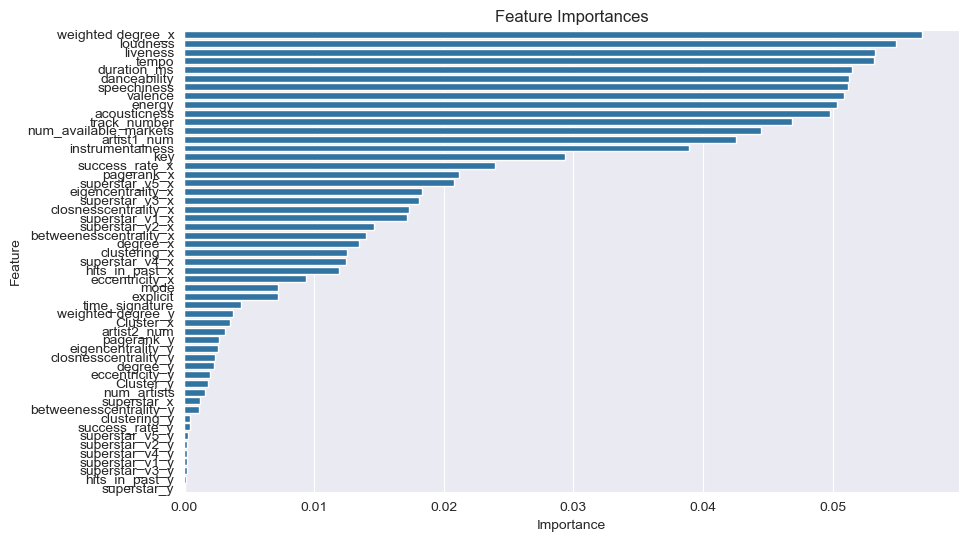

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get the feature importances
importances = clf.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [12]:
from sklearn import metrics

y_pred = clf.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


predictions = y_pred.round().astype(int).tolist()  # Converting array to list of integers
true_labels = y_test.astype(int).tolist()  # Converting array to list of integers

confusion_matrix = metrics.confusion_matrix(true_labels, predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])

# Extract TN, FP, TP values
TN = confusion_matrix[0, 0]  # True Negatives
FP = confusion_matrix[0, 1]  # False Positives
FN = confusion_matrix[1, 0]  # False Negatives
TP = confusion_matrix[1, 1]  # True Positives

# Print the results
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Positives (TP):", TP)

# Precision
precision = metrics.precision_score(true_labels, predictions)
# Recall
recall = metrics.recall_score(true_labels, predictions)
# F1-Score
f1 = metrics.f1_score(true_labels, predictions)

fpr, tpr, thresholds = metrics.roc_curve(true_labels, predictions)
roc_auc = metrics.auc(fpr, tpr)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

y_pred_proba = clf.predict_proba(X_test)
# print(y_pred_proba)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = metrics.auc(fpr, tpr)
print("ROC AUC:", roc_auc)

# Generate a classification report
class_report = metrics.classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

count_occ = y_test.value_counts(normalize=True)

# Calculate the weighted accuracy
weighted_acc = (np.sum((y_test == 1) == y_pred) * count_occ[0] + np.sum((y_test == 0) == y_pred) * count_occ[1]) / len(
    y_test)

print("Weighted Accuracy:", weighted_acc)

f1_scores = []
for label in np.unique(y_test):
    f1 = metrics.f1_score(y_test == label, y_pred == label)
    f1_scores.append(f1)

# Calculate the macro F1 score by taking the average
macro_f1 = np.mean(f1_scores)

print("Macro F1 Score:", macro_f1)

roc_auc_scores = []
for i in range(len(np.unique(y))):
    # Convert y_test to binary labels for the current class
    y_binary = np.array([1 if label == i else 0 for label in y_test])
    # Calculate ROC AUC score for the current class
    roc_auc = metrics.roc_auc_score(y_binary, y_pred_proba[:, i])
    roc_auc_scores.append(roc_auc)

# Average ROC AUC scores across all classes
average_roc_auc = np.mean(roc_auc_scores)

print("ROC AUC scores for each class:", roc_auc_scores)
print("Average ROC AUC score:", average_roc_auc)

Accuracy: 0.9869308755760369
True Negatives (TN): 53508
False Positives (FP): 209
False Negatives (FN): 500
True Positives (TP): 33
Precision: 0.13636363636363635
Recall: 0.06191369606003752
F1-Score: 0.08516129032258064
ROC AUC: 0.7417477936015239
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     53717
         1.0       0.14      0.06      0.09       533

    accuracy                           0.99     54250
   macro avg       0.56      0.53      0.54     54250
weighted avg       0.98      0.99      0.98     54250

Weighted Accuracy: 0.977362796067022
Macro F1 Score: 0.539289858435832
ROC AUC scores for each class: [0.7417477237475629, 0.7417477936015239]
Average ROC AUC score: 0.7417477586745433


this result is only valid for excluding the upsampling...

now big with prep

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

data = pd.read_csv("data_superstar_v1_0.csv", delimiter=",")
data['date'] = pd.to_datetime(data['release_date'])
data.sort_values(by="date", inplace=True)


# Drop columns not in the list
data["explicit"] = data["explicit"].astype(int)


def find_min_max(df):
    # Select only numeric columns
    numeric_cols = df.select_dtypes(include=['number'])

    # Find max and min values for each numeric column
    min_max_values = {}
    for col in numeric_cols.columns:
        min_value = df[col].min()
        max_value = df[col].max()
        min_max_values[col] = {'min': min_value, 'max': max_value}

    return min_max_values


min_max_val = find_min_max(data)

y = data["hit"]
X = data.drop(columns=["hit"])


def preprocess(df, min_max_values, exclude_cols=None):
    missing_numerical = df.select_dtypes(include=['number']).isnull().sum()
    # Fill missing values with mean for each numeric attribute
    imputer = SimpleImputer(strategy='mean')
    df_filled = df.copy()
    for col in missing_numerical.index:
        if missing_numerical[col] > 0:
            df_filled[col] = imputer.fit_transform(df[[col]])

    # Normalize numerical features into [0, 1] range with MinMaxScaler
    if exclude_cols:
        numerical_cols = df_filled.select_dtypes(include=['number']).columns.difference(exclude_cols)
    else:
        numerical_cols = df_filled.select_dtypes(include=['number']).columns

    # print("numerical columns:", numerical_cols)

    for column_name in numerical_cols:
        df_filled[column_name] = (df_filled[column_name] - min_max_values[column_name]["min"]) / (
                min_max_values[column_name]["max"] - min_max_values[column_name]["min"])

    df_normalized = pd.DataFrame(df_filled, columns=numerical_cols)

    # One-hot encode categorical features
    encoder = OneHotEncoder(handle_unknown='ignore')
    if exclude_cols:
        categorical_cols = df.select_dtypes(include=['object']).columns.difference(exclude_cols)
    else:
        categorical_cols = df.select_dtypes(include=['object']).columns
    df_encoded = encoder.fit_transform(df[categorical_cols])

    # print(categorical_cols)

    # Convert the sparse matrix to dense array
    df_encoded_dense = df_encoded.toarray()

    # Concatenate numerical and encoded categorical features
    df_processed = np.hstack([df_normalized.values, df_encoded_dense])

    return df_processed

# split_day = X["date"].iloc[-1] - pd.DateOffset(years=1)
# X_train = X[(X["date"] < split_day)].copy()
# X_test = X[(X["date"] >= split_day)].copy()
# 
# sep_index = X_train.shape[0]
# y_train = y.iloc[:sep_index].copy()
# y_test = y.iloc[sep_index:].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [14]:
X_train.drop(columns=["song_popularity"], inplace=True)
X_test.drop(columns=["song_popularity"], inplace=True)

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 683270 entries, 0 to 683433
Data columns (total 65 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   song_id                 683270 non-null  object        
 1   song_name               683270 non-null  object        
 2   explicit                683270 non-null  int32         
 3   song_type               683270 non-null  object        
 4   track_number            683270 non-null  float64       
 5   num_artists             683270 non-null  float64       
 6   num_available_markets   683270 non-null  float64       
 7   release_date            683270 non-null  object        
 8   duration_ms             683270 non-null  float64       
 9   key                     683270 non-null  float64       
 10  mode                    683270 non-null  float64       
 11  time_signature          683270 non-null  float64       
 12  acousticness            683270 non-

In [16]:
X_train

,song_id,song_name,explicit,song_type,track_number,num_artists,num_available_markets,release_date,duration_ms,key,...,superstar_v4_y,superstar_v5_x,superstar_v5_y,success_rate_x,success_rate_y,hits_in_past_x,hits_in_past_y,superstar_x,superstar_y,date
0,7kXUEJmfvRXbzxOC0pHQgb,I Can't Believe I'm Losing You,0,Solo,12.0,1.0,79.0,1995-01-01,162667.0,10.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,1995-01-01
3659,1qWiKzVrG0GQd1qbgKCsSF,I've Grown Accustomed To Her Face,0,Solo,2.0,1.0,79.0,1995-01-01,349120.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,1995-01-01
3658,1oNYa5jcL10TbXQSPRgbsk,Come Back To Me,0,Solo,5.0,1.0,2.0,1995-01-01,206093.0,2.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,1995-01-01
3657,7A131DrpfbWAfNJLrxikwf,Top Of The Stairs,0,Solo,4.0,1.0,2.0,1995-01-01,271307.0,7.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,1995-01-01
3656,4SRjOJm5AjO3fxXpZSTEBb,Never Crossed My Mind,0,Solo,3.0,1.0,2.0,1995-01-01,242027.0,7.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,1995-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683396,6ERuMuUWQzSgCwOqTSrSVT,How High the Moon,0,Solo,20.0,1.0,79.0,2015-08-19,149844.0,7.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,2015-08-19
683430,1dvxuoNz7e603WUjrDaP4V,Back To Back - Originally performed by Drake (...,1,Solo,2.0,1.0,79.0,2015-08-19,171102.0,8.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,2015-08-19
683431,7dQU5mlVd5AXX5YqmIKZE2,Back To Back - Originally performed by Drake,1,Solo,1.0,1.0,79.0,2015-08-19,171102.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,2015-08-19
683432,522tmFx0Rlm1Jex8hl2QIl,Metal Militia (Karaoke Version) [Originally Pe...,0,Solo,3.0,1.0,79.0,2015-08-19,319671.0,9.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,2015-08-19


In [17]:
X_test

,song_id,song_name,explicit,song_type,track_number,num_artists,num_available_markets,release_date,duration_ms,key,...,superstar_v4_y,superstar_v5_x,superstar_v5_y,success_rate_x,success_rate_y,hits_in_past_x,hits_in_past_y,superstar_x,superstar_y,date
683434,4dc4MQpoLDPHBMt2Mk4dih,Of Wolf And Man (Karaoke Version) [Originally ...,0,Solo,8.0,1.0,79.0,2015-08-19,269429.0,11.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,2015-08-19
683435,34nOomrSFivFip6cncJs9u,Orion (Karaoke Version) [Originally Performed ...,0,Solo,10.0,1.0,79.0,2015-08-19,484199.0,9.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,2015-08-19
683436,16hQ1I04XaMJCh0PKMGL6J,Fire N Gold - Originally performed by Bea Mill...,0,Solo,2.0,1.0,79.0,2015-08-19,211566.0,6.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,2015-08-19
683437,70mPtAGxAAqyXtCCMMaPjO,Hell Of A Night - Originally performed by Dust...,0,Solo,1.0,1.0,79.0,2015-08-19,189388.0,6.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,2015-08-19
683438,5moCAm36r7LFbVumnMY3dl,Alone No More - Originally performed by Philip...,0,Solo,1.0,1.0,79.0,2015-08-19,167053.0,5.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,2015-08-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911001,1EeuFwQ7RhTNlPg69LGUxM,All the Kids on the Street,0,Solo,6.0,1.0,79.0,2019-08-23,192401.0,2.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,2019-08-23
911000,2O9CikWfjkYAgGCBws5Pl4,Baby I'll Give It to You,0,Solo,25.0,1.0,76.0,2019-08-23,194907.0,8.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,2019-08-23
911025,2CZ46u5NGXQFXke3PMCuAK,Today I Started Loving You Again,0,Solo,15.0,1.0,78.0,2019-08-23,172147.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,2019-08-23
911012,6zhg8TnVKi90ITDzFKwPr0,Swingtown - Alternate Version,0,Solo,5.0,1.0,79.0,2019-08-23,205707.0,9.0,...,1.0,1.0,1.0,0.0,0.0,0,0,0,0,2019-08-23


In [18]:
X_train["profile_x"] = X_train["profile_x"].astype(str)
X_train["profile_y"] = X_train["profile_y"].astype(str)
X_train["song_type"] = X_train["song_type"].astype(str)
X_test["profile_x"] = X_test["profile_x"].astype(str)
X_test["profile_y"] = X_test["profile_y"].astype(str)
X_test["song_type"] = X_test["song_type"].astype(str)

In [19]:
X_train = X_train.select_dtypes(exclude=['object']) #include onehot enc for some string values /different encod
X_train.drop(columns="date", inplace=True)
X_test = X_test.select_dtypes(exclude=['object']) #include onehot enc for some string values /different encod
X_test.drop(columns="date", inplace=True)

In [20]:
feature_names = X_train.columns
X_train = preprocess(X_train, min_max_val)
X_test = preprocess(X_test, min_max_val)

In [21]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
from sklearn import metrics

y_pred = clf.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


predictions = y_pred.round().astype(int).tolist()  # Converting array to list of integers
true_labels = y_test.astype(int).tolist()  # Converting array to list of integers

confusion_matrix = metrics.confusion_matrix(true_labels, predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])

# Extract TN, FP, TP values
TN = confusion_matrix[0, 0]  # True Negatives
FP = confusion_matrix[0, 1]  # False Positives
FN = confusion_matrix[1, 0]  # False Negatives
TP = confusion_matrix[1, 1]  # True Positives

# Print the results
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Positives (TP):", TP)

# Precision
precision = metrics.precision_score(true_labels, predictions)
# Recall
recall = metrics.recall_score(true_labels, predictions)
# F1-Score
f1 = metrics.f1_score(true_labels, predictions)

fpr, tpr, thresholds = metrics.roc_curve(true_labels, predictions)
roc_auc = metrics.auc(fpr, tpr)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

y_pred_proba = clf.predict_proba(X_test)
# print(y_pred_proba)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = metrics.auc(fpr, tpr)
print("ROC AUC:", roc_auc)

# Generate a classification report
class_report = metrics.classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

count_occ = y_test.value_counts(normalize=True)

# Calculate the weighted accuracy
weighted_acc = (np.sum((y_test == 1) == y_pred) * count_occ[0] + np.sum((y_test == 0) == y_pred) * count_occ[1]) / len(
    y_test)

print("Weighted Accuracy:", weighted_acc)

f1_scores = []
for label in np.unique(y_test):
    f1 = metrics.f1_score(y_test == label, y_pred == label)
    f1_scores.append(f1)

# Calculate the macro F1 score by taking the average
macro_f1 = np.mean(f1_scores)

print("Macro F1 Score:", macro_f1)

roc_auc_scores = []
for i in range(len(np.unique(y))):
    # Convert y_test to binary labels for the current class
    y_binary = np.array([1 if label == i else 0 for label in y_test])
    # Calculate ROC AUC score for the current class
    roc_auc = metrics.roc_auc_score(y_binary, y_pred_proba[:, i])
    roc_auc_scores.append(roc_auc)

# Average ROC AUC scores across all classes
average_roc_auc = np.mean(roc_auc_scores)

print("ROC AUC scores for each class:", roc_auc_scores)
print("Average ROC AUC score:", average_roc_auc)

Accuracy: 0.9963074680470853
True Negatives (TN): 225080
False Positives (FP): 551
False Negatives (FN): 290
True Positives (TP): 1836
Precision: 0.7691663175534144
Recall: 0.863593603010348
F1-Score: 0.8136494571238644
ROC AUC: 0.9633855492950922
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    225631
         1.0       0.77      0.86      0.81      2126

    accuracy                           1.00    227757
   macro avg       0.88      0.93      0.91    227757
weighted avg       1.00      1.00      1.00    227757

Weighted Accuracy: 0.9870418939741207
Macro F1 Score: 0.9058923581237291
ROC AUC scores for each class: [0.9633855492950921, 0.9633855492950922]
Average ROC AUC score: 0.9633855492950922


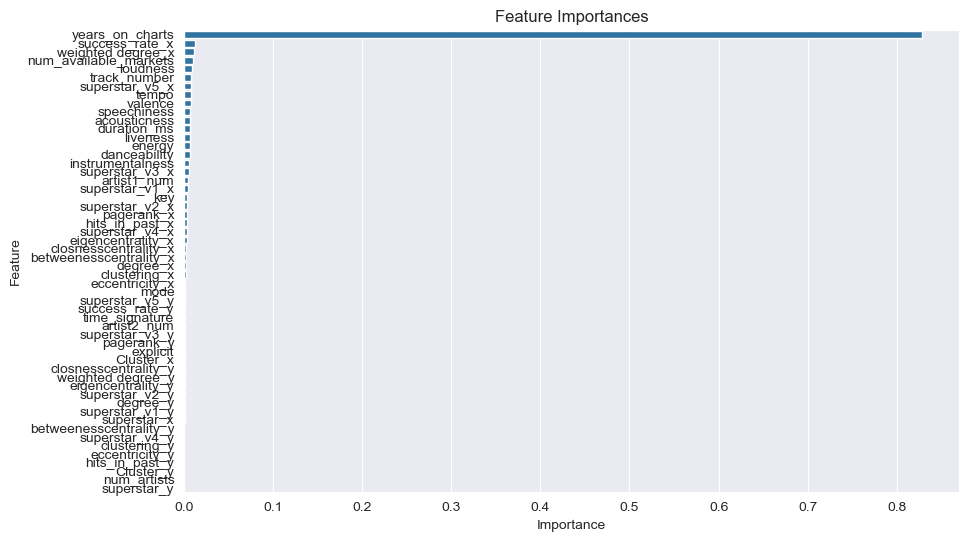

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get the feature importances
importances = clf.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [24]:
X_train.shape

(683270, 54)

In [25]:
len(feature_names)

54

# Shap Analysis

In [26]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
